# CHAPTER 6 게이트가 추가된 RNN

5장에서 본 RNN은 순환 경로를 포함하여 과거의 정보를 기억할 수 있으며, 구조가 단순하여 구현도 쉬움  
하지만 시계열 데이터에서 시간적으로 멀리 떨어진, 장기 의존 관계를 잘 학습할 수 없다는 단점이 있음  
  
LSTM이나 GRU에는 '게이트'라는 구조가 더해져서 장기 의존 관계를 학습할 수 있음

## 6.1 RNN의 문제점

RNN은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문에 시계열 데이터의 장기 의존 관계를 학습하기 어려움  

### 6.1.1 RNN 복습

<img src='./img/6/RNN_1.png' width=500>  

<img src='./img/6/RNN_1.png' width=500>  
  
RNN 계층은 시계열 데이터인 $x_t$를 입력하면 $h_t$를 출력함  
$h_t$는 RNN 계층의 은닉상태라고 하여, 과거 정보를 저장함  
이를 이용하여 과거 정보를 계승할 수 있음  
  
<img src='./img/6/RNN_2.png' width=500>  
  
RNN 계층의 순전파 계산그래프는 위의 그림과 같다.  
행렬의 곱과 합, 활성화 함수인 tanh 함수에 의한 변환으로 구성됨

### 6.1.2 기울기 소실 또는 기울기 폭발

언어 모델은 주어진 단어들을 기초로 다음에 출현할 단어를 예측하는 일을 함  
  
RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있음  
기울기는 원래대로라면 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습함  
  
하지만 기존에 다뤘던 RNN 계층은 시간을 거슬러 올라갈수록 기울기가 작아지거나(기울기 소실) 혹은 커지는(기울기 폭발) 문제가 발생함

### 6.1.3 기울기 소실과 기울기 폭발의 원인

<기존 RNN의 역전파 계산그래프>  
  
<img src='./img/6/RNN_3.png' width=500>  
  
기존 RNN에서 역전파로 전해지는 기울기는 차례로 'tanh', '+', 'MatMul(행렬 곱)' 연산을 통과함  
  
여기서, tanh 함수의 그래프를 그려보면 아래와 같다. 

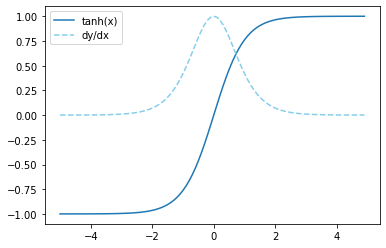

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-5,5,0.1)
y = np.tanh(x)
partial_y = 1-y**2

plt.plot(x,y,label='tanh(x)')
plt.plot(x,partial_y,'--',label='dy/dx',color='skyblue')
plt.legend()

y = tanh(x)의 미분값은 1.0 이하며, x가 0에서 멀어질수록 작아짐  
따라서, 역전파에서 기울기가 tanh 노드를 지날 때마다 값이 계속 작아짐  
  
-------
< 참고 >  
  
RNN 계층의 활성화 함수로는 주로 tanh 함수를 사용하는데, 이를 ReLU로 바꾸면 기울기 소실을 줄일 수 있음. ReLU는 입력 x가 0 이상이면 역전파 시 상류의 기울기를 그대로 하류에 흘려보내기 때문에 기울기가 작아지지 않음   

-------
  
MatMul(행렬 곱) 노드의 역전파는 상류로부터 흘러온 기울기 dh와 $W_h^T$ 행렬 곱으로 기울기를 계산함  
행렬 곱셈에서는 매번 똑같은 가중치를 사용하므로 같은 계산을 시계열 데이터의 시간 크기만큼 반복하게 됨  
  
MatMul 노드에서 일어나는 기울기의 변화는 아래 두 예시에서 확인할 수 있다.

Text(0, 0.5, 'norm')

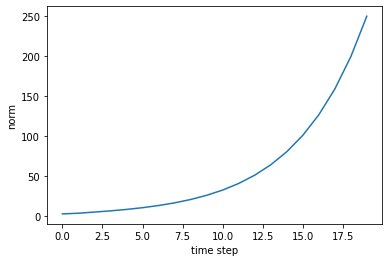

In [2]:
# 예시 1

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # L2 norm
    norm_list.append(norm)
    
plt.plot(np.arange(20), norm_list)
plt.xlabel('time step'); plt.ylabel('norm')

기울기의 크기가 시간에 비례해 지수적으로 증가함  
이 것을 기울기 폭발(exploding gradients)라고 함  

Text(0, 0.5, 'norm')

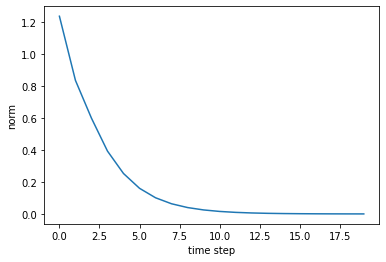

In [3]:
# 예시 2(초깃값 변경)

N = 2
H = 3 
T = 20

dh = np.ones((N, H))
np.random.seed(3)
# Wh = np.random.randn(H, H) # 기존
Wh = np.random.randn(H,H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N 
    norm_list.append(norm)
    
plt.plot(np.arange(20), norm_list)
plt.xlabel('time step'); plt.ylabel('norm')

$W_h$의 초깃값을 변경한 위 실험에서는 기울기가 지수적으로 감소함  
이건 기울기 소실(vanishing gradients)라고 함  
이런 경우, 기울기가 일정 수준 이하로 작아지면 가중치 매개변수가 더 이상 갱신되지 않으므로, 장기 의존 관계를 학습할 수 없음  
  
즉, $W_h$를 T번 반복해서 곱했기 때문에 지수적으로 증가하거나 감소하게 됨  
($W_h$가 행렬인 경우 특잇값의 최댓값이 1보다 크면 지수적으로 증가, 1보다 작으면 지수적으로 감소할 가능성이 높음)

### 6.1.4 기울기 폭발 대책

__기울기 클리핑(gradients clipping)__  
  
기울기 폭발의 대책으로 전통적인 기법으로 알고리즘을 의사 코드로 쓰면 다음과 같음  
  
if   $\parallel\hat g\parallel \geq threshold:
\hat g=\frac{threshold}{\parallel\hat g\parallel}\hat g$  
  
- $\hat g$ : 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은 것  
- treshold : 문턱값
- $\parallel\hat g\parallel$ : 기울기의 L2 노름  
  
기울기의 L2노름이 문턱값 이상이면 위 식과 같이 기울기를 수정함  

In [4]:
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2] # 기울기를 하나로 모음
max_norm = 5.0 # threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 6.2 기울기 소실과 LSTM

게이트를 추가하여 기울기 소실 문제를 개선함  
게이트가 추가된 RNN의 대표격 모델로는 LSTM과 GRU가 있음  
  
-----  
  
<img src='./img/6/node.png' width=700>  
  
이번 절에서는 가독성을 고려해 계산그래프를 단순화하여 그림  
ex) 위의 예시. $tanh(h_{t-1}W_h+x_tW_x+b)$라는 계산을 tanh라는 직사각형 하나로 그림

### 6.2.1 LSTM의 인터페이스

<img src='./img/6/LSTM_1.png' width=500>

위 그림과 같이 LSTM 계층의 인터페이스에는 c라는 경로가 있음  
c를 기억 셀(memory cell) 혹은 단순히 셀이라고 하며, LSTM 전용의 기억 메커니즘임  
  
기억 셀은 데이터를 LSTM 계층 내에서만 주고 받음(다른 계층으로는 출력되지 않음)  

### 6.2.2 LSTM 계층 조립하기

<img src='./img/6/LSTM_gate_1.png' width=400>  
  
기억 셀 $c_t$에는 과거로부터 시각 t까지에 필요한 모든 기억(정보)이 저장되어 있음  
이 기억을 바탕으로 외부 계층과 다음 시각의 LSTM에 은닉 상태 $h_t$를 출력함  
이 때 $h_t$는 기억 셀의 값을 tanh 함수로 변환한 값임($h_t=tanh(c_t)$)  
  
그림과 같이 $c_t$의 값은 3개의 입력($c_{t-1}, h_{t-1}, x_t$)으로부터 '여러 계산'을 수행하여 구함  
$h_t$는 '여러 계산'을 통해 갱신된 $c_t$의 값을 tanh 함수를 변환한 값임  
  
__게이트__  
게이트는 데이터의 흐름을 제어함  
LSTM에서 사용하는 게이트는 물의 흐름을 제어하는 '문'처럼 열거나 닫을 수 있을 뿐아니라, 어느 정도 열지도 조절할 수 있음  
여기서 '어느 정도'를 '열림 상태(openness)'라고 부름  

게이트는 게이트의 열림 상태를 제어하기 위해서 전용 가중치 매개변수를 이용하며,  
이 가중치 매개변수는 학습 데이터로부터 갱신됨  
즉, 게이트를 얼마나 열지는 데이터로부터 자동으로 학습 함  
게이트의 열림 상태를 구할 때는 시그모이드 함수를 사용함  
따라서 게이트의 열림 상태는 0.0 ~ 1.0 사이의 실수로 나타남(1.0은 완전 개방)  

### 6.2.3 output 게이트

<img src='./img/6/LSTM_gate_2.png' width=400>  

__output 게이트__(출력게이트) : 다음 은닉 상태 $h_t$의 출력을 담당하는 게이트  
$tanh(c_t)$의 각 원소에 대해 '다음 시각의 은닉 상태에 얼마나 중요한가'를 조정함  
  
output 게이트의 열림 상태(다음 몇 %만 흘려보낼지)는 입력 $x_t$와 이전 상태 $h_{t-1}$로부터 구함  
  
$o=\sigma(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$  
(output 게이트임을 표시하기 위해 첫 글자인 o를 첨자로 표시함)  
  
여기서 구한 o와 $tanh(c_t)$의 원소별 곱(아다마르 곱, 기호 : $\odot$)을 $h_t$로 출력  
  
$h_t=o\odot tanh(c_t)$

### 6.2.4 forget 게이트

<img src='./img/6/LSTM_gate_3.png' width=400>  

__forget 게이트__(망각게이트) : $c_{t-1}$의 기억 중에서 불필요한 기억을 잊게 해주는 게이트  
  
$f=\sigma(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$  
  
여기서 구한 f와 이전 기억 셀인 $c_{t-1}$과의 원소별 곱으로 $c_t$를 구함  
  
$c_t=f\odot c_{t-1}$

### 6.2.5 새로운 기억 셀

<img src='./img/6/LSTM_gate_4.png' width=400>  

forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제되었으니,  
이제 새로 기억해야 할 정보를 기억 셀에 추가해야 함  
  
tanh 노드가 계산한 결과가 이전 시각의 기억 셀 $c_{t-1}$에 더해짐  
이렇게 기억 셀에 새로운 '정보'가 추가됨!  
  
이 tanh 노드는 '게이트'가 아닌 새로운 '정보'를 기억 셀에 추가하는 것이 목적이므로  
활성화 함수로는 시그모이드가 아닌 tanh 함수를 사용함  
  
$g = tanh(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})$  
  
g가 이전 시각의 기억 셀 $c_{t-1}$에 더해짐으로서 새로운 기억이 생김

--------
  
< 참고 >  
  
tanh의 출력은 -1.0 ~ 1.0의 실수  
이 수치를 그 안에 인코딩된 '정보'의 강약(정도)을 표시한다고 해석할 수 있음  
  
시그모이드 함수의 출력은 0.0 ~ 1.0의 실수  
데이터를 얼마나 통과시킬지를 정하는 비율을 뜻함  
  
따라서 주로 게이트에서는 시그모이드 함수가, 실질적인 '정보'를 지니는 데이터에는 tanh 함수가 활성화 함수로 사용됨!  
  
------

### 6.2.6 input 게이트

<img src='./img/6/LSTM_gate_5.png' width=400>  

__input 게이트__(입력게이트) : g의 각 원소가 새로 추가되는 정보로써 가치가 얼마나 큰지를 판단함  
input 게이트에 의해 가중된 정보가 새로 추가 되는 거라고 볼 수 있음  
  
$i = \sigma(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$  
  
i와 g의 원소별 곱 결과를 기억 셀에 추가함

### 6.2.7 LSTM의 기울기 흐름

<img src='./img/6/LSTM_2.png' width=800>

LSTM(Long Short-Term Memory)은 단기 기억을 긴 시간 지속할 수 있음을 의미함  
  
위 그림은 기억 셀의 역전파 흐름(파란 화살표)을 나타냄  
기억 셀의 역전파는 '+'와 '$\times$' 노드만을 지남  
  
기존의 RNN의 역전파에서는 똑같은 가중치 행렬을 사용하여 행렬곱을 반복하여 기울기 소실 또는 기울기 폭발이 일어났음    
반면, LSTM의 역전파에서 '$\times$' 노드는 매 시각 다른 게이트 값을 이용해 '행렬 곱'이 아닌 '원소별 곱(아마다르 곱)'을 계산함  
매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나기 어려움  
  
이 '$\times$' 노드는 forget 게이트가 제어함  
forget 게이트가 잊어야 한다고 판단한 기억 셀의 원소에 대해서는 기울기가 작아짐  
한편, forget 게이트가 잊어서는 안된다고 판단한 원소에 대해서는 기울기가 약화되지 않은 채로 과거 방향으로 전해짐  

## 6.3 LSTM 구현

LSTM에서 수행하는 계산은 다음과 같다.  
  
- $f = \sigma(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$  
  
  
- $g = tanh(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})$  
  
  
- $i = \sigma(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$  
  
  
- $o = \sigma(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$  
  
  
- $c_t = f\odot c_{t-1}+g\odot i$  
  
  
- $h_t = o\odot tanh(c_t)$  
  
여기서 위에서 네 개 수식에 포함된 아핀 변환(affine transformation, 행렬 변환과 평행 이동(편향)을 결합한 형태)은  
아래 그림과 같이 하나의 식으로 정리할 수 있음  
  
<img src='./img/6/LSTM_3.png' width=500>  
  
이 변환을 통한 행렬의 형상을 보면 다음과 같다.  
  
<img src='./img/6/LSTM_4.png' width=500>  
  
- N : 미니배치 수
- D : 입력 데이터의 차원 수
- H : 기억 셀과 은닉 상태의 차원 수(동일)  
  
계산 결과인 A에는 네 개분의 아핀 변환 결과가 저장됨  
  
LSTM의 계산 그래프는 다음과 같다.  
  
<img src='./img/6/LSTM_5.png' width=800>  
  
4개분의 아핀 변환을 한꺼번에 수행한 후 slice 노드를 통해 아핀 변환의 결과(행렬)을 균등하게 네 조각으로 나눠서 분배함  
(그 후엔 시그모이드 함수 또는 tanh 함수를 거쳐 앞에서 설명한 계산 과정을 수행함)  
  
<img src='./img/6/LSTM_6.png' width=400>  
  
slice 노드에서 행렬을 네 조각으로 분배했음  
따라서, 역전파에서는 반대로 4개의 기울기를 결합해야 함  
  
이 부분은 코드에서 np.hstack() 메서드를 사용함  
np.hstack()은 배열을 가로로 연결함(세로 연결은 np.vstack())


In [5]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### 6.3.1 Time LSTM 구현

T개분의 시계열 데이터를 한꺼번에 처리하는 Time LSTM 구현  
  
Truncated BPTT는 역전파의 연결은 적당한 길이로 끊고, 순전파의 흐름은 그대로 유지해야 함  
따라서 은닉 상태와 기억 셀을 인스턴스 변수로 유지

In [6]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

LSTM을 사용한 언어 모델 구현  
  
여기서 구현하는 언어 모델은 앞 장에서 구현한 언어모델에서 TIME RNN 계층이 TIME LSTM 계층으로 바뀐 것 빼고는 동일함

In [7]:
from common.time_layers import *
from common.base_model import BaseModel

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

이 신경망을 사용해 PTB 데이터셋 학습

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.72
| 에폭 1 |  반복 21 / 1327 | 시간 2[s] | 퍼플렉서티 3133.70
| 에폭 1 |  반복 41 / 1327 | 시간 5[s] | 퍼플렉서티 1239.48
| 에폭 1 |  반복 61 / 1327 | 시간 7[s] | 퍼플렉서티 981.69
| 에폭 1 |  반복 81 / 1327 | 시간 10[s] | 퍼플렉서티 776.86
| 에폭 1 |  반복 101 / 1327 | 시간 12[s] | 퍼플렉서티 658.28
| 에폭 1 |  반복 121 / 1327 | 시간 15[s] | 퍼플렉서티 632.17
| 에폭 1 |  반복 141 / 1327 | 시간 17[s] | 퍼플렉서티 577.08
| 에폭 1 |  반복 161 / 1327 | 시간 20[s] | 퍼플렉서티 575.51
| 에폭 1 |  반복 181 / 1327 | 시간 22[s] | 퍼플렉서티 580.85
| 에폭 1 |  반복 201 / 1327 | 시간 25[s] | 퍼플렉서티 504.31
| 에폭 1 |  반복 221 / 1327 | 시간 27[s] | 퍼플렉서티 494.13
| 에폭 1 |  반복 241 / 1327 | 시간 30[s] | 퍼플렉서티 436.90
| 에폭 1 |  반복 261 / 1327 | 시간 32[s] | 퍼플렉서티 444.08
| 에폭 1 |  반복 281 / 1327 | 시간 35[s] | 퍼플렉서티 446.29
| 에폭 1 |  반복 301 / 1327 | 시간 37[s] | 퍼플렉서티 392.38
| 에폭 1 |  반복 321 / 1327 | 시간 40[s] | 퍼플렉서티 341.22
| 에폭 1 |  반복 341 / 1327 | 시간 42[s] | 퍼플렉서티 399.95
| 에폭 1 |  반복 361 / 1327 | 시간 44[s] | 퍼플렉서티 404.14
| 에폭 1 |  반복 381 / 1327 | 시간 47[s] | 퍼플렉서티 332.91
| 

| 에폭 3 |  반복 541 / 1327 | 시간 466[s] | 퍼플렉서티 136.84
| 에폭 3 |  반복 561 / 1327 | 시간 469[s] | 퍼플렉서티 118.81
| 에폭 3 |  반복 581 / 1327 | 시간 472[s] | 퍼플렉서티 105.75
| 에폭 3 |  반복 601 / 1327 | 시간 475[s] | 퍼플렉서티 150.29
| 에폭 3 |  반복 621 / 1327 | 시간 479[s] | 퍼플렉서티 141.44
| 에폭 3 |  반복 641 / 1327 | 시간 482[s] | 퍼플렉서티 127.51
| 에폭 3 |  반복 661 / 1327 | 시간 485[s] | 퍼플렉서티 120.07
| 에폭 3 |  반복 681 / 1327 | 시간 488[s] | 퍼플렉서티 100.40
| 에폭 3 |  반복 701 / 1327 | 시간 491[s] | 퍼플렉서티 117.89
| 에폭 3 |  반복 721 / 1327 | 시간 494[s] | 퍼플렉서티 125.07
| 에폭 3 |  반복 741 / 1327 | 시간 498[s] | 퍼플렉서티 106.99
| 에폭 3 |  반복 761 / 1327 | 시간 501[s] | 퍼플렉서티 101.88
| 에폭 3 |  반복 781 / 1327 | 시간 504[s] | 퍼플렉서티 105.00
| 에폭 3 |  반복 801 / 1327 | 시간 507[s] | 퍼플렉서티 116.23
| 에폭 3 |  반복 821 / 1327 | 시간 510[s] | 퍼플렉서티 117.10
| 에폭 3 |  반복 841 / 1327 | 시간 513[s] | 퍼플렉서티 114.27
| 에폭 3 |  반복 861 / 1327 | 시간 516[s] | 퍼플렉서티 120.35
| 에폭 3 |  반복 881 / 1327 | 시간 519[s] | 퍼플렉서티 106.74
| 에폭 3 |  반복 901 / 1327 | 시간 522[s] | 퍼플렉서티 132.64
| 에폭 3 |  반복 921 / 1327 | 시간 52

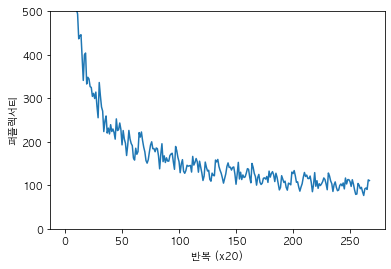

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.08055323787798


In [6]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25    # 기울기 클리핑 적용

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20) # 20번째 반복마다 퍼플렉시티를 평가
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state() # 모델의 은닉 상태와 기억 셀 재설정 해줘야 함!
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

## 6.5 RNNLM 추가 개선

### 6.5.1 LSTM 계층 다층화

<img src='./img/6/LSTM_7.png' width=400>  
  
LSTM 계층을 몇 층이라도 쌓을 수 있으며, 그 결과 더 복잡한 패턴을 학습할 수 있음

### 6.5.2 드롭아웃에 의한 과적합 억제

LSTM 계층을 층을 깊게 쌓음으로써 표현력이 풍부한 모델을 만들 수 있음  
하지만 층이 깊은 모델은 종종 과적합(overfitting)을 일으킴  
RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킴  
  
과적합을 억제하는 방법으로 '훈련 데이터의 양 늘리기', '모델의 복잡도 줄이기', '모델의 복잡도에 페널티를 주는 정규화' 등의 방법이 있음  
  
또, 드롭아웃(dropout)처럼 훈련 시 계층 내의 뉴런 몇 개를 무작위로 무시하고 학습하는 방법도 일종의 정규화라고 할 수 있음  
  
드롭아웃은 무작위로 뉴런을 선택하여 무시함  
RNN에서 시계열 방향으로 드롭아웃을 넣으면 학습 시 시간이 흐름에 따라 정보가 사라질 수 있음  
즉, 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적됨  
  
따라서 아래 그림처럼 드롭아웃 계층을 시간축과는 독립적으로 상하 방향으로 삽입하는게 좋음  
  
<img src='./img/6/dropout_1.png' width=500>

위에서 언급한 것처럼 일반적인 드롭아웃은 시간 방향에는 적합하지 않음  
그러나 시간 방향으로 적용할 수 있는 변형 드롭아웃(Variational Dropout)이 나옴!  
  
변형 드롭아웃은 깊이 방향은 물론 시간 방향에도 이용할 수 있어서 언어 모델의 정확도를 한 층 더 향상시킬 수 있음  
같은 계층에 속한 드롭아웃들은 같은 마스크(mask)를 공유함  
여기서, '마스크'란 데이터의 '통과/차단'을 결정하는 이진(binary)형태의 무작위 패턴을 가리킴  
  
아래 그림에서 볼 수 있듯이 같은 계층 드롭아웃끼리 마스크를 공유함으로써 마스크가 '고정'됨  
정보를 잃게 되는 방법도 '고정'되므로, 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있음  
  
<img src='./img/6/dropout_2.png' width=800>

### 6.5.3 가중치 공유

<img src='./img/6/LSTM_8.png' width=250>  
  
가중치 공유(weight tying) : Embedding 계층의 가중치와 Affine 계층의 가중치를 연결하는(공유하는) 기법  
  
두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도가 향상됨  
(매개변수 수가 줄어든다 함은 과적합이 억제되는 혜택으로 이어질 수 있음)  
  
Embedding 계층의 가중치는 형상이 $V\times H$이고  
Affine 계층의 가중치 형상은 $H\times V$임  
따라서, Embedding 계층의 가중치를 전치하여 Affine 계층의 가중치로 설정

### 6.5.4 개선된 RNNLM 구현

<img src='./img/6/LSTM_9.png' width=250>
위에서 언급한 개선점 3개를 반영하여 BetterRnnlm 클래스로 구현  
  
- LSTM 계층의 다층화(2층)  
- 드롭아웃 사용(깊이 방향으로 적용)  
- 가중치 공유(Embedding 계층, Affine 계층)  

In [8]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 세 가지 개선
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

개선된 BetterRnnlm 클래스 학습  
  
여기서는 매 에폭에서 검증 데이터로 퍼플렉서티를 평가하고, 그 값이 나빠졌을 경우에만 학습률을 낮춤(1/4로 설정했음)  
(이 기술은 실전에서 자주 쓰임)  

In [ ]:
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

테스트 데이터로 얻은 최종 퍼플렉서티는 75.76 정도가 됨  
개선 전 RNNLM의 퍼플렉서티가 100 이상이었음을 생각하면 상당히 개선된 것을 알 수 있음  

# APPENDIX C GRU

LSTM은 매개변수가 많아서 계산이 오래 걸린다는 단점이 있음  
GRU(Gated Recurrent Unit)은 게이트를 사용한다는 개념은 유지한 채, 매개변수를 줄여 계산 시간을 줄인 모델

## C.1 GRU의 인터페이스

LSTM의 핵심인 게이트는 학습 시 기울기를 원활하게 흘려주어 기울기 소실을 줄임  
GRU도 같은 사상을 계승하나, 계층의 인터페이스가 다름  

<img src='./img/6/GRU_1.png' width=500>  
  
위 그림과 같이 GRU는 LSTM을 '더 단순하게' 만든 아키텍처로 기억 셀 없이 은닉 상태만 사용함  

## C.2 GRU의 계산 그래프

<img src='./img/6/GRU_2.png' width=500>

GRU 내부에서 수행하는 계산은 다음과 같다.  
  
$z=\sigma(x_tW_x^{(z)}+h_{t-1}W_h^{(z)}+b^{(z)})$  
$r=\sigma(x_tW_x^{(r)}+h_{t-1}W_h^{(r)}+b^{(r})$  
$\tilde{h}=tanh(x_tW_x+(r\odot h_{t-1})W_h+b)$  
$h_t=(1-z)\odot h_{t-1}+z\odot \tilde{h}$  
  
GRU에는 기억 셀은 없고 시간 방향으로 전파하는 것은 은닉 상태 h뿐임  
r과 z라는 2개의 게이트를 사용함  
  
__reset 게이트__ : 과거의 은닉 상태를 얼마나 '무시'할지를 정함  
만약 r이 0이면 새로운 은닉 상태 $\tilde{h}$는 입력 $x_t$만으로 결정됨  
즉, 과거의 은닉 상태는 완전히 무시됨  
  
__update 게이트__ : 은닉 상태를 갱신하는 게이트  
LSTM의 forget 게이트와 input 게이트의 역할을 update 게이트에서 수행함  
forget 게이트로서의 기능은 다음 식 $(1-z)\odot h_{t-1}$에 따라 과거의 은닉 상태에서 잊어야 할 정보를 삭제함  
input 게이트로서의 기능은 $z\odot \tilde{h}$ 부분으로 새로 추가된 정보에 가중치를 부여함